In [2]:
!pip install --upgrade scikit-learn

  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [34]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

weather_path = "s3://sagemaker-project-p-o3c1kiruwcnf/bdd100k_images/predictions/combined/weather-v3.parquet"
timeofday_path = "s3://sagemaker-project-p-o3c1kiruwcnf/bdd100k_images/predictions/combined/timeofday-v3.parquet"
scene_path = "s3://sagemaker-project-p-o3c1kiruwcnf/bdd100k_images/predictions/combined/scene-v3.parquet"

In [54]:
def calculate_stats(path):
    df = pd.read_parquet(path)
    
    # Calculate Truth Distribution
    truth_dist = df.copy()
    truth_dist = truth_dist.groupby(['truth'])['name'].agg('count').to_frame(name = 'Truth')
    
    # Calculate Prediction Distribution
    pred_dist = df.copy()
    pred_dist = pred_dist.groupby(['prediction'])['name'].agg('count').to_frame(name = 'Predictions')
    
    truth_dist.join(pred_dist).plot.bar()
    plt.show();
    
    # Calculate Accuracy          
    accuracy = metrics.accuracy_score(df['truth'], df['prediction'])
    print(f"Accuracy: {accuracy}")
    
    # Calculate Confusion Matrix
    matrix = metrics.ConfusionMatrixDisplay.from_predictions(df['truth'], df['prediction'], normalize = 'true', xticks_rotation = 'vertical', values_format = '.1%')

    
    report = metrics.classification_report(df['truth'], df['prediction'])
    plt.show();
    print(report)
    
    
    # Calculate Confidence When Right/Wrong
    temp = df.copy()
    temp['is_correct'] = np.where(temp['truth'] == temp['prediction'], 'Correct', 'Incorrect')
    temp.groupby('is_correct')['prediction_confidence'].plot.hist(bins = 25, alpha=0.5)
    
    plt.show();
    
    # Confidence Gap
    temp = df.copy()
    keep = temp['truth'] != temp['prediction']
    temp['confidence_gap'] = temp['prediction_confidence'] - temp['correct_answer_confidence']
    temp[keep]['confidence_gap'].plot.hist(bins = 25)
    
    plt.show();
    
    # Rank Values
    temp_min = df.copy()
    temp_min['rank'] = temp_min.groupby('truth')['correct_answer_confidence'].rank(method = 'first')
    keep = (temp_min['rank'] == 1)
    temp_min = temp_min[keep]
    
    temp_max = df.copy()
    temp_max['rank'] = temp_max.groupby('truth')['correct_answer_confidence'].rank(method = 'first', ascending = False)
    keep = (temp_max['rank'] == 1)
    temp_max = temp_max[keep]
    
    return pd.concat([temp_min, temp_max]).sort_values('truth') #.drop('rank', axis = 1)

# Weather

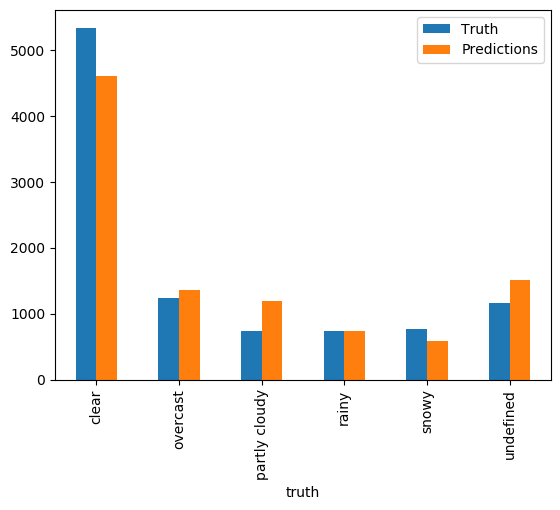

Accuracy: 0.7409


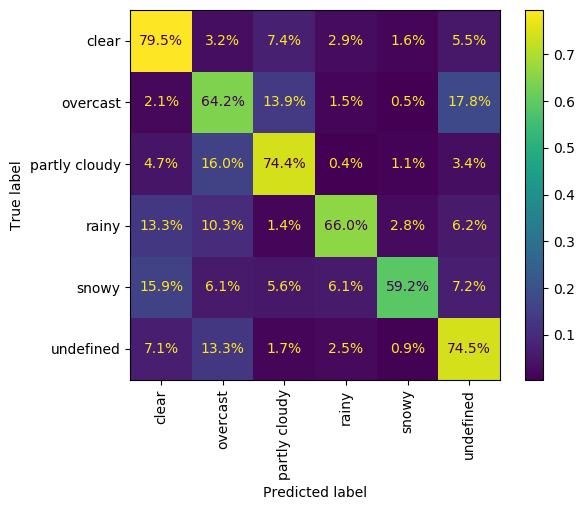

               precision    recall  f1-score   support

        clear       0.92      0.79      0.85      5346
     overcast       0.58      0.64      0.61      1239
partly cloudy       0.46      0.74      0.57       738
        rainy       0.66      0.66      0.66       738
        snowy       0.78      0.59      0.67       769
    undefined       0.58      0.75      0.65      1170

     accuracy                           0.74     10000
    macro avg       0.66      0.70      0.67     10000
 weighted avg       0.77      0.74      0.75     10000



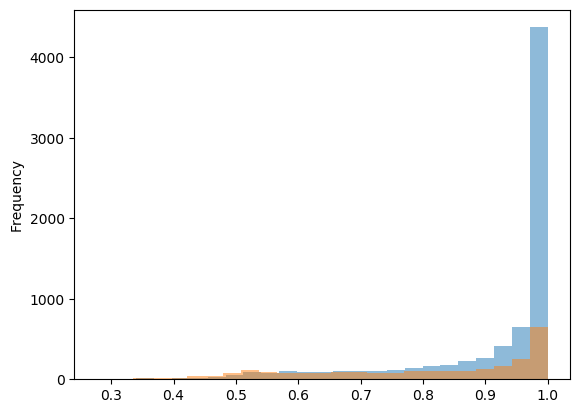

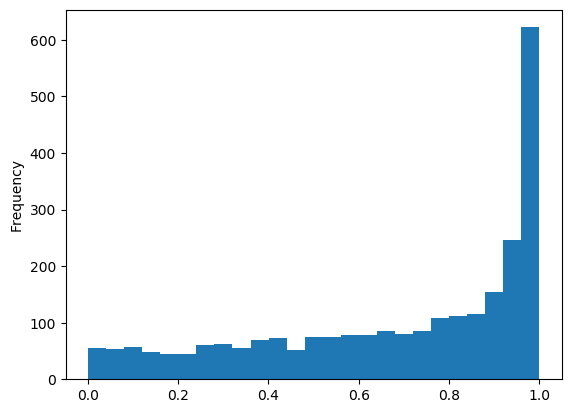

,name,model,truth,prediction,prediction_confidence,correct_answer_confidence,rainy,snowy,clear,overcast,partly cloudy,undefined,rank
9976,ca656c47-876ad414.jpg,weather,clear,overcast,0.996691,4.163537e-08,4.452153e-07,5.951817e-09,4.163537e-08,9.966908e-01,3.292733e-03,1.599121e-05,1.0
2462,b7d13f97-0aec1868.jpg,weather,clear,clear,0.999999,9.999992e-01,7.490075e-07,7.633659e-11,9.999992e-01,2.285116e-08,5.078472e-08,7.011587e-08,1.0
9371,c8f1cdd6-9d2a3186.jpg,weather,overcast,undefined,0.999989,7.762388e-07,3.992864e-10,5.137286e-10,9.804071e-06,7.762388e-07,8.357040e-07,9.999886e-01,1.0
5030,be85bd88-d849c034.jpg,weather,overcast,overcast,0.999996,9.999958e-01,1.286041e-06,1.026854e-09,1.539464e-07,9.999958e-01,6.275802e-07,2.181048e-06,1.0
964,b43bcc83-c97d569e.jpg,weather,partly cloudy,overcast,0.999818,1.404747e-05,1.541034e-04,1.410386e-05,9.210788e-08,9.998176e-01,1.404747e-05,1.538535e-07,1.0
2872,b8fb5451-6c0e5ec6.jpg,weather,partly cloudy,partly cloudy,0.999999,9.999987e-01,2.314949e-09,1.642040e-08,1.080226e-06,1.973925e-07,9.999987e-01,1.776139e-09,1.0
9290,c8c0c00c-5a90317a.jpg,weather,rainy,overcast,0.999762,3.782905e-07,3.782905e-07,3.364717e-09,3.064182e-07,9.997615e-01,2.376147e-04,1.393638e-07,1.0
6392,c1b16eee-d45c1777.jpg,weather,rainy,rainy,1.000000,1.000000e+00,1.000000e+00,4.945988e-09,2.056847e-11,2.336737e-10,5.521446e-10,1.441714e-08,1.0
4961,be5c5aae-d31145ff.jpg,weather,snowy,overcast,0.998578,1.344947e-07,1.900335e-05,1.344947e-07,1.834207e-06,9.985782e-01,8.380162e-05,1.317098e-03,1.0
8197,c60deb3c-d8219cc9.jpg,weather,snowy,snowy,1.000000,1.000000e+00,1.903964e-08,1.000000e+00,2.024722e-08,9.079037e-09,1.546336e-08,1.549037e-08,1.0


In [55]:
calculate_stats(weather_path)

# Scene

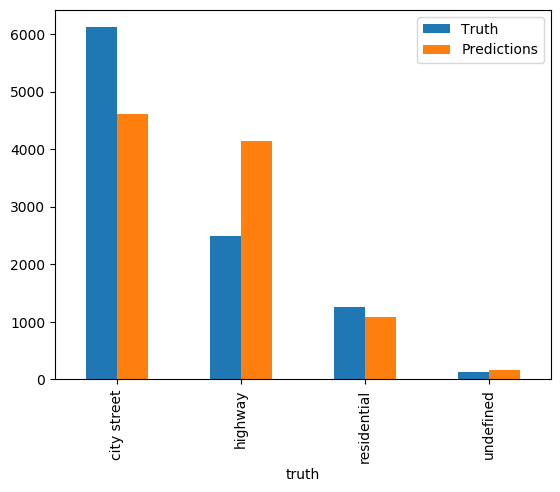

Accuracy: 0.6742


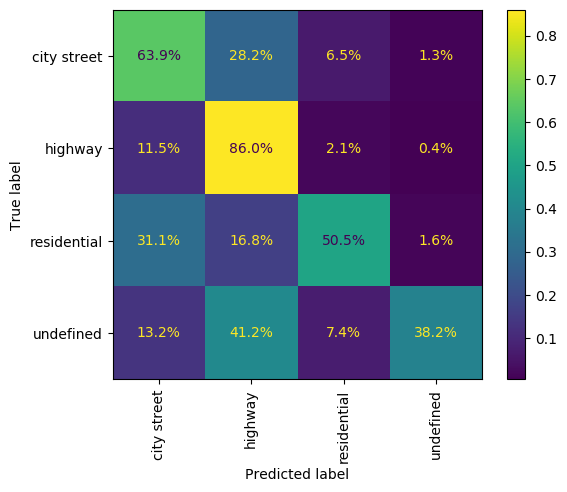

              precision    recall  f1-score   support

 city street       0.85      0.64      0.73      6112
     highway       0.52      0.86      0.65      2499
 residential       0.58      0.51      0.54      1253
   undefined       0.32      0.38      0.35       136

    accuracy                           0.67     10000
   macro avg       0.57      0.60      0.57     10000
weighted avg       0.73      0.67      0.68     10000



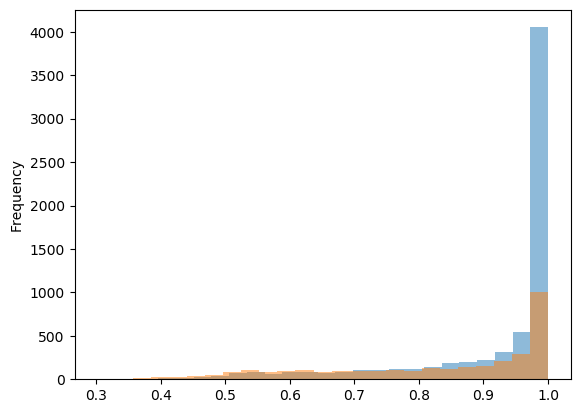

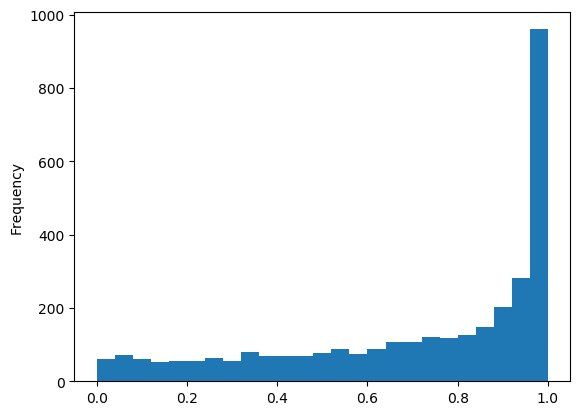

,name,model,truth,prediction,prediction_confidence,correct_answer_confidence,residential,city street,highway,undefined,rank
3295,ba36b0a9-6c380330.jpg,scene,city street,highway,1.000000,1.405204e-07,6.528469e-08,1.405204e-07,9.999998e-01,1.157377e-08,1.0
3397,ba7efc39-e3e9eecf.jpg,scene,city street,city street,1.000000,9.999999e-01,5.938865e-09,9.999999e-01,2.898213e-08,8.613161e-08,1.0
22,b1d0a191-de8948f6.jpg,scene,highway,city street,0.999648,7.359756e-06,2.948518e-04,9.996481e-01,7.359756e-06,4.965991e-05,1.0
965,b43de6e1-f20e4351.jpg,scene,highway,highway,1.000000,1.000000e+00,4.245074e-14,6.954068e-12,1.000000e+00,4.333731e-11,1.0
3777,bb8dba97-3537805c.jpg,scene,residential,highway,0.999997,3.681204e-09,3.681204e-09,2.550926e-06,9.999970e-01,4.361756e-07,1.0
6076,c11a0015-fa2086af.jpg,scene,residential,residential,1.000000,1.000000e+00,1.000000e+00,3.511536e-08,8.605681e-10,2.642641e-08,1.0
4577,bd6dcefc-68d695b9.jpg,scene,undefined,highway,0.953080,1.787042e-05,6.678570e-03,4.022323e-02,9.530804e-01,1.787042e-05,1.0
6248,c1715aef-9c4e4c40.jpg,scene,undefined,undefined,0.999680,9.996803e-01,3.099672e-05,9.874791e-06,2.788465e-04,9.996803e-01,1.0


In [56]:
calculate_stats(scene_path)

# Time of Day

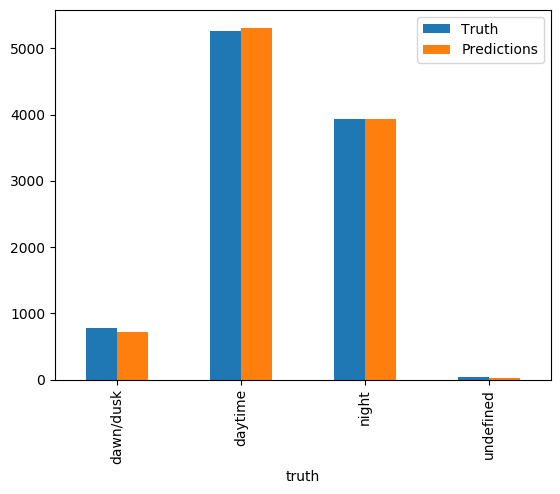

Accuracy: 0.9225


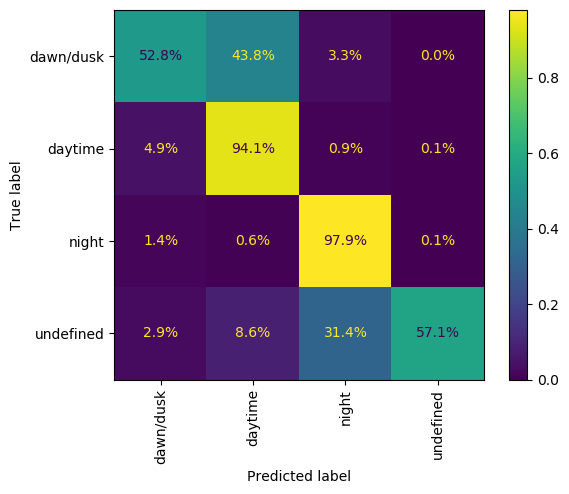

              precision    recall  f1-score   support

   dawn/dusk       0.57      0.53      0.55       778
     daytime       0.93      0.94      0.94      5258
       night       0.98      0.98      0.98      3929
   undefined       0.74      0.57      0.65        35

    accuracy                           0.92     10000
   macro avg       0.80      0.75      0.78     10000
weighted avg       0.92      0.92      0.92     10000



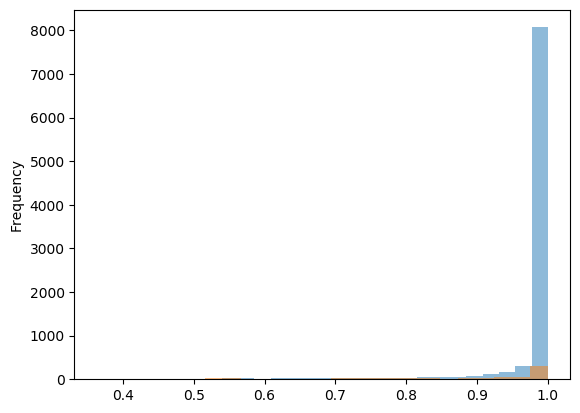

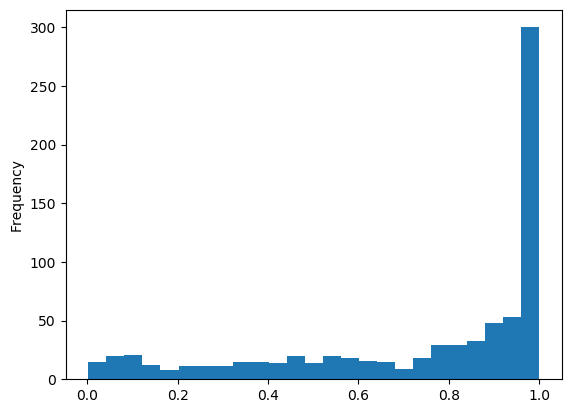

,name,model,truth,prediction,prediction_confidence,correct_answer_confidence,daytime,night,dawn/dusk,undefined,rank
5640,c0082590-683d229f.jpg,timeofday,dawn/dusk,daytime,0.999995,2.289875e-08,9.999948e-01,5.755040e-07,2.289875e-08,4.644585e-06,1.0
9776,c9df3b7e-bb72e430.jpg,timeofday,dawn/dusk,dawn/dusk,0.999999,9.999992e-01,4.066865e-07,1.178301e-07,9.999992e-01,3.643154e-07,1.0
806,b3c4e98b-2788a3e8.jpg,timeofday,daytime,night,0.999890,2.309720e-07,2.309720e-07,9.998897e-01,9.175398e-07,1.090557e-04,1.0
50,b1da9c53-0f3d4c5d.jpg,timeofday,daytime,daytime,1.000000,1.000000e+00,1.000000e+00,7.448250e-10,5.762308e-09,4.328550e-08,1.0
1206,b4c755fa-1ce17fa3.jpg,timeofday,night,daytime,1.000000,4.637145e-08,9.999995e-01,4.637145e-08,8.631790e-08,3.505661e-07,1.0
6063,c1025fcf-69509758.jpg,timeofday,night,night,0.999998,9.999982e-01,7.462717e-09,9.999982e-01,1.109561e-07,1.703341e-06,1.0
2316,b7799f64-736f7f7e.jpg,timeofday,undefined,daytime,0.999890,9.983504e-05,9.998903e-01,9.742610e-06,2.543451e-08,9.983504e-05,1.0
6248,c1715aef-9c4e4c40.jpg,timeofday,undefined,undefined,0.999777,9.997765e-01,1.932702e-04,1.658272e-05,1.365941e-05,9.997765e-01,1.0


In [57]:
calculate_stats(timeofday_path)